In [1]:
import torch

In [2]:
import sys
sys.path.append('..')
from src.dataset import load_dataset
from src.model import load_model
from src.utils import imshow

author = input('who are you? ').lower()
if author == 'bumjin':
    from src.bumjin.gradient_method import smooth_gradient, vanilla_gradient, integrated_gradient
elif author == 'cheongwoong':
    from src.cheongwoong.gradient_method import smooth_gradient, vanilla_gradient, integrated_gradient
elif author == 'hyukdong':
    from src.hyukdong.gradient_method import smooth_gradient, vanilla_gradient, integrated_gradient
elif author == 'soyeon':
    from src.soyeon.gradient_method import smooth_gradient, vanilla_gradient, integrated_gradient

who are you? bumjin


In [3]:
###############################################################
# Prepare dataset
###############################################################

trainset, testset, classes = load_dataset('CIFAR10')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
###############################################################
# Load a trained model
###############################################################

model = load_model('baseline', 'cifar10_baseline.pth')
model = model.to(device)

In [6]:
###############################################################
# Hyperparameters
###############################################################

args = {
    'model': model,
    'device': device,
    
    'M': 10,
    'sigma': 0.2,
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


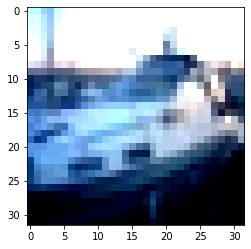

label: ship 

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
output prob: tensor([0.2985, 0.1149, 0.0114, 0.0048, 0.0121, 0.0013, 0.0006, 0.0046, 0.4761,
        0.0758])
pred: ship 

shape check: torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) torch.Size([3, 32, 32])


In [7]:
###############################################################
# Run XAI algorithm on a target instance
###############################################################
idx = 2

x, y = testset[idx]
x_baseline = torch.zeros_like(x)

imshow(x)
print('label:', classes[y], '\n')

logits = model(x.to(device).unsqueeze(0))[0]
prob = torch.softmax(logits, 0)
prediction = classes[torch.argmax(logits)]
print(classes)
print('output prob:', prob.detach().cpu())
print('pred:', prediction, '\n')

args.update({
    'x': x.to(device),
    'baseline': x_baseline.to(device),
    'target_class': torch.tensor(y).to(device),
})

ig = integrated_gradient(**args)['attribution']
sg = smooth_gradient(**args)['attribution']
vg = vanilla_gradient(**args)['attribution']

print('shape check:', x.shape, ig.shape, sg.shape, vg.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


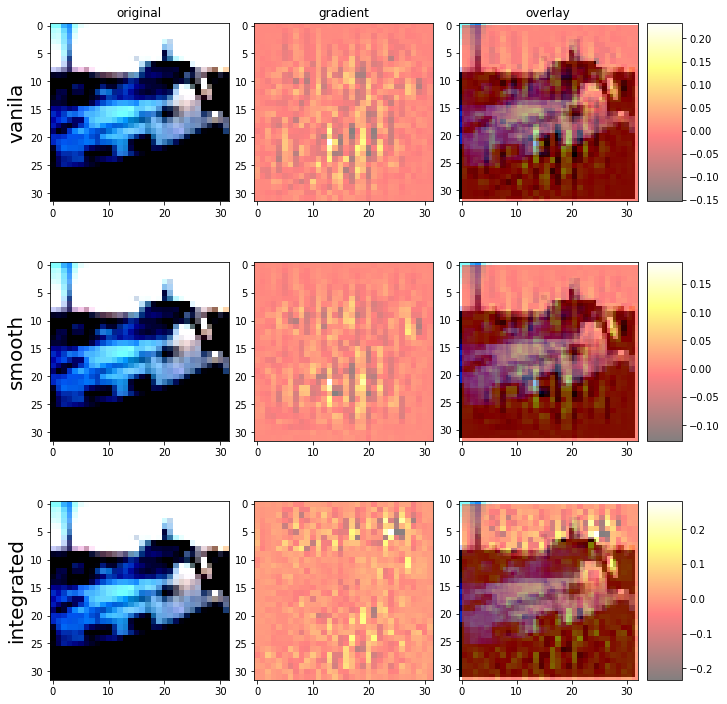

In [8]:
###############################################################
# Visualization
###############################################################

from matplotlib import pyplot as plt
import copy 
fig, ax = plt.subplots(3, 3, constrained_layout=True, figsize=(10,10))

for i, (input_attribution, name) in enumerate(zip([vg, sg, ig], ["vanila", "smooth", 'integrated'])):
    input = x.detach().cpu().permute(1,2,0)
    input_attribution = input_attribution.sum(0).squeeze(0).cpu()
#     input_attribution = input_attribution / 2*input_attribution.abs().max() + 1/2
    ax[i][0].imshow(input, cmap='binary')
    ax[i][1].imshow(copy.deepcopy(input_attribution), alpha=0.5, cmap='hot')
    ax[i][2].imshow(input, cmap='binary')
    ax[i][0].set_ylabel(name, fontsize=20)

ax[0][0].set_title("original")
ax[0][1].set_title("gradient")
ax[0][2].set_title("overlay")

pcm1 = ax[0][2].pcolormesh(vg.sum(0).squeeze(0).cpu(), alpha=0.5, cmap='hot')
cax = ax[0][2].inset_axes([1.05, 0.0, 0.2, 1.0], transform=ax[0][2].transAxes)
fig.colorbar(pcm1, ax=ax[0][2], cax=cax)

pcm2 = ax[1][2].pcolormesh(sg.sum(0).squeeze(0).cpu(), alpha=0.5, cmap='hot')
cax = ax[1][2].inset_axes([1.05, 0.0, 0.2, 1.0], transform=ax[1][2].transAxes)
fig.colorbar(pcm2, ax=ax[1][2], cax=cax)

pcm3 = ax[2][2].pcolormesh(ig.sum(0).squeeze(0).cpu(), alpha=0.5, cmap='hot')
cax = ax[2][2].inset_axes([1.05, 0.0, 0.2, 1.0], transform=ax[2][2].transAxes)
fig.colorbar(pcm3, ax=ax[2][2], cax=cax)
plt.show()